<a href="https://colab.research.google.com/github/dctime/minecraft-texture-generation/blob/main/texture_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import zipfile
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os
np.set_printoptions(floatmode='fixed')

In [52]:
with zipfile.ZipFile('drive/MyDrive/Minecraft Texture Generator/minecraft_texture_with_resized_16.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [53]:
# for filename in os.listdir('dataset/minecraft_texture_with_resize_16'):
#     print(filename)

In [63]:
# ds = tf.keras.preprocessing.image_dataset_from_directory('/content/dataset', image_size=(16, 16), batch_size=1)
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     '/content/dataset',
#     batch_size=16,
#     image_size=(16, 16))
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(16, 16),
    batch_size=16)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/dataset',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(16, 16),
    batch_size=16)

train_dataset = train_dataset.map(lambda x, y: x)
validation_dataset = validation_dataset.map(lambda x, y: x)
print(train_dataset)
print(validation_dataset)

Found 39461 files belonging to 1 classes.
Using 31569 files for training.
Found 39461 files belonging to 1 classes.
Using 7892 files for validation.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 16, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 16, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [64]:
for images in train_dataset[0]:
  image = images[0]
  plt.imshow(image.numpy().astype("uint8"))
  plt.show()
  break

TypeError: ignored

In [56]:
def scale_img(img_ndarray):
  processing = img_ndarray/255
  return processing


train_dataset = train_dataset.map(scale_img)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.prefetch(buffer_size=128)
print(train_dataset)


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 16, 16, 3), dtype=tf.float32, name=None)>


In [57]:
def build_generator():
  model = Sequential()

  model.add(Dense((4*4*128), input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((4, 4, 128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(3, 5, padding='same', activation='sigmoid'))


  return model

In [23]:
build_generator().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2048)              264192    
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 8, 128)         409728    
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                      

In [24]:
def build_discriminator():
  # input 16x16x3
  model = Sequential()

  model.add(Conv2D(16, 5, padding='valid', input_shape = (16, 16, 3)))
  model.add(LeakyReLU(0.3))

  model.add(Conv2D(32, 3, padding='valid'))
  model.add(LeakyReLU(0.3))

  model.add(Conv2D(64, 3, padding='valid'))
  model.add(LeakyReLU(0.3))

  model.add(Conv2D(128, 3, padding='valid'))
  model.add(LeakyReLU(0.3))

  model.add(Conv2D(256, 3, padding='valid'))
  model.add(LeakyReLU(0.3))

  model.add(Conv2D(512, 3, padding='valid'))
  model.add(LeakyReLU(0.3))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))



  return model

In [25]:
build_discriminator().summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 12, 12, 16)        1216      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 12, 12, 16)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 10, 10, 32)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 conv2d_41 (Conv2D)          (None, 6, 6, 128)        

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 2048)              264192    
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 8, 8, 128)         409728    
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                     

1/1 [==============================] - 0s 104ms/step
[[[-1.29773579e+00]
  [-6.82371461e-01]
  [ 1.13549539e+00]
  [-5.91931879e-01]
  [ 6.25366572e-01]
  [ 8.57561579e-02]
  [ 7.65397631e-01]
  [-3.80236992e-01]
  [-4.19718128e-02]
  [ 6.46912696e-01]
  [-2.69778113e-01]
  [ 3.02921834e-01]
  [-1.37725254e-02]
  [ 1.70688787e-01]
  [-1.11864870e+00]
  [ 1.31746344e+00]
  [ 4.57185957e-01]
  [ 5.20690783e-01]
  [ 5.30239342e-01]
  [ 4.94281124e-01]
  [-2.12799907e+00]
  [-1.50839797e+00]
  [ 2.01332458e+00]
  [-3.51094936e-01]
  [-1.15302365e+00]
  [-9.75755163e-01]
  [ 2.10289666e+00]
  [ 5.60254358e-01]
  [-7.34098027e-01]
  [ 3.04645469e-01]
  [ 5.27293578e-03]
  [-1.22352097e+00]
  [ 2.05549109e-01]
  [ 7.01644274e-01]
  [-1.04796701e+00]
  [-1.48510567e+00]
  [-2.88988715e+00]
  [ 5.65195690e-02]
  [-5.23867420e-01]
  [ 2.12335809e+00]
  [ 5.66205703e-03]
  [ 1.52249065e+00]
  [-6.37505510e-02]
  [-3.22249104e-01]
  [-5.34487615e-01]
  [ 1.72526251e-01]
  [ 6.51111282e-02]
  [-6.3

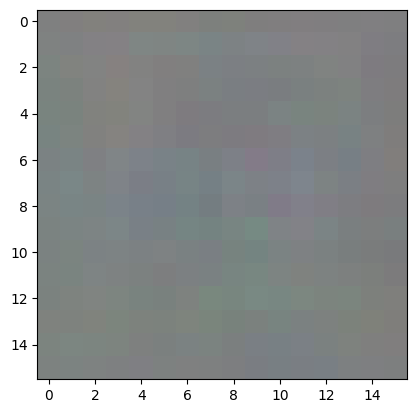

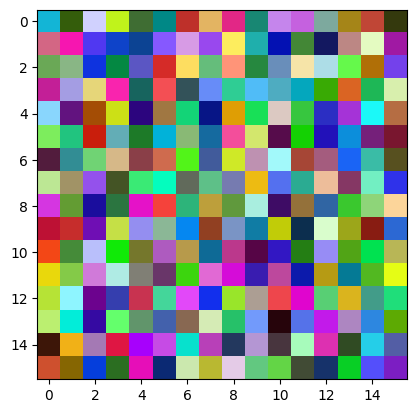

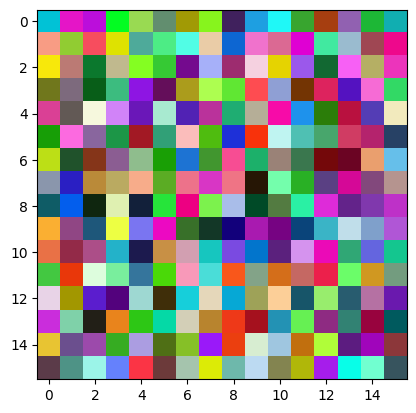

In [58]:
generator = build_generator()
generator.summary()
img = generator.predict(np.random.randn(3, 128, 1))
print(np.random.randn(3, 128, 1))
for index in range(3):
  img = img*255
  plt.imshow(img[index].astype("uint8"))
  plt.show()

In [27]:
discriminator = build_discriminator()
discriminator.predict(tf.random.normal((16, 16, 16, 3)))

1/1 [==============================] - 0s 83ms/step


array([[0.49864084],
       [0.48775288],
       [0.51216668],
       [0.49873850],
       [0.48600525],
       [0.46996814],
       [0.49026003],
       [0.48623377],
       [0.48350161],
       [0.49520171],
       [0.48314980],
       [0.50231761],
       [0.49417925],
       [0.49131441],
       [0.48460782],
       [0.49468493]], dtype=float32)

In [59]:
class MinecraftTextureGAN(Model):
  def __init__(self, generator, discriminator, batch_size, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.batch_size = batch_size

  def compile(self, g_loss, d_loss, g_optimizer, d_optimizer, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.g_loss_f = g_loss
    self.d_loss_f = d_loss
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer

  def train_step(self, batch_of_data):
    # train the discriminator
    with tf.GradientTape() as d_tape:
      real_img = batch_of_data
      # print(real_img.shape)
      fake_img = generator(tf.random.normal((self.batch_size, 128, 1)), training=False)
      # print(fake_img.shape)

      real_and_fake_img = tf.concat([real_img, fake_img], axis=0)

      zeros = tf.zeros((self.batch_size, 1))
      random_arr = np.random.uniform(low=0.0, high=0.15, size=zeros.shape)
      zeros = zeros + random_arr

      ones = tf.ones((self.batch_size, 1))
      random_arr = np.random.uniform(low=0.0, high=0.15, size=ones.shape)
      ones = ones - random_arr

      real_and_fake_img_label = tf.concat([zeros, ones], axis=0)
      discriminator_prediction = self.discriminator(real_and_fake_img, training=True)
      # print(real_and_fake_img_label)
      # print(discriminator_prediction.shape)
      # print(real_and_fake_img_label.shape)

      d_loss = self.d_loss_f(real_and_fake_img_label, discriminator_prediction)
      # print(d_loss)

    d_gradient = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

    # train the generator
    with tf.GradientTape() as g_tape:
      generated_images = self.generator(tf.random.normal((self.batch_size, 128, 1)), training=True)

      trick_discriminator_prediction = self.discriminator(generated_images, training=False)
      generated_label = tf.ones((self.batch_size, 1))
      # print(trick_discriminator_prediction.shape)
      # print(generated_label.shape)

      g_loss = self.g_loss_f(generated_label, trick_discriminator_prediction)
      # print(g_loss)

    g_gradient = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

    return {'generator_loss': g_loss, 'discriminator_loss': d_loss}

In [60]:
class Monitor(Callback):
  def __init__(self, num_img, seed_dim):
    super().__init__()
    self.num_img = num_img
    self.seed_dim = seed_dim

  def on_epoch_end(self, epoch, logs=None):
    random_seed = tf.random.uniform((self.num_img, self.seed_dim, 1))
    generated_images = self.model.generator(random_seed)
    generated_images *= 255 # turn it back to normal images
    generated_images.numpy()
    for i in range(self.num_img): # loop from index 0 to num_img-1
      image = array_to_img(generated_images[i])
      image.save(os.path.join('images', f'generated_images_{epoch}_{i}.png'))


In [61]:
model = MinecraftTextureGAN(build_generator(), build_discriminator(), 16)
model.compile(BinaryCrossentropy(), BinaryCrossentropy(), Adam(learning_rate=0.001), Adam(learning_rate=0.0001))
# history = model.fit(train_dataset, epochs=50, callbacks=[Monitor(5, 128)])
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
1923/1974 [============================>.] - ETA: 0s - generator_loss: 2.2203 - discriminator_loss: 0.3029

InvalidArgumentError: ignored